## Brain Tumor Detection using an Ensemble of VGG16 and a Hybrid CNN-Transformer

This notebook builds two advanced models and combines their predictions:
1.  **VGG16 with Transfer Learning:** Leverages pre-trained knowledge.
2.  **Hybrid CNN-Transformer:** Combines the local feature extraction of a CNN with the global context understanding of a Transformer.

### Step 1: Setup - Mount Google Drive and Unzip Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/MyDrive/Dataset/Brain Tumor MRI images.zip' '/content/dataset.zip'

!rm -rf /content/dataset

!unzip -q /content/dataset.zip -d /content/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 2: Load and Preprocess the Data

In [1]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

DATA_DIR = '/content/drive/MyDrive/Dataset/Brain Tumor MRI images'
CATEGORIES = ['Tumor', 'Healthy']
IMG_SIZE = 150

def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
    return training_data

print("Loading and preprocessing data...")
training_data = create_training_data()
random.shuffle(training_data)

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data prepared!")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading and preprocessing data...
Data prepared!
Training data shape: (4074, 150, 150, 3)
Testing data shape: (1019, 150, 150, 3)


### Step 3: Build and Train Model 1 (VGG16 with Transfer Learning)

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model_vgg.layers:
    layer.trainable = False

x_vgg = base_model_vgg.output
x_vgg = Flatten()(x_vgg)
x_vgg = Dense(256, activation='relu')(x_vgg)
x_vgg = Dropout(0.5)(x_vgg)
predictions_vgg = Dense(1, activation='sigmoid')(x_vgg)

vgg_model = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the VGG16 Model...")
vgg_history = vgg_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

vgg_model.save('brain_tumor_vgg16.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training the VGG16 Model...
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.8275 - loss: 0.3672 - val_accuracy: 0.9706 - val_loss: 0.0978
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.9554 - loss: 0.1193 - val_accuracy: 0.9814 - val_loss: 0.0622
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9761 - loss: 0.0735 - val_accuracy: 0.9755 - val_loss: 0.0636
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9733 - loss: 0.0725 - val_accuracy: 0.9804 - val_loss: 0.0596
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9774 - loss: 0.0561 - val_accuracy: 0.9853 - val_loss: 0.0376
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.9805 - loss: 0.0581 - val_accuracy: 0.9902 - val_loss: 0.0344
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9820 - loss: 0.0518 - val_accuracy: 0.9814 - val_loss: 0.0457
Epoc

### Step 4: Build and Train Model 2 (Hybrid CNN-Transformer)

In [3]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Input, Reshape, Add, Conv2D, MaxPooling2D

# --- Define the Transformer Encoder Block ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])


def build_cnn_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)

    # CNN Feature Extractor
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Create Patches
    _, h, w, c = x.shape
    x = Reshape((h * w, c))(x)

    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)


    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)


hybrid_model = build_cnn_transformer_model(
    (IMG_SIZE, IMG_SIZE, 3),
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.25,
    mlp_dropout=0.4,
)

hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

print("\nTraining the Hybrid CNN-Transformer Model...")
hybrid_history = hybrid_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_test, y_test),
    verbose=1
)

hybrid_model.save('brain_tumor_hybrid_cnn_transformer.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 289, 128)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 289, 128)  │        256 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 289, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 289, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 289, 128)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 289, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 289, 4)    │        516 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 289, 4)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 289, 128)  │        640 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 289, 128)  │          0 │ dense_3[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 289, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,945,105 (26.49 MB)

 Trainable params: 6,945,105 (26.49 MB)

 Non-trainable params: 0 (0.00 B)


Training the Hybrid CNN-Transformer Model...
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5905 - loss: 3.9988 - val_accuracy: 0.5927 - val_loss: 0.6885
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.5797 - loss: 0.6883 - val_accuracy: 0.5927 - val_loss: 0.6838
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.5937 - loss: 0.6828 - val_accuracy: 0.5927 - val_loss: 0.6807
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.6006 - loss: 0.6788 - val_accuracy: 0.5927 - val_loss: 0.6788
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.6025 - loss: 0.6762 - val_accuracy: 0.5927 - val_loss: 0.6775
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.5851 - loss: 0.6794 - val_accuracy: 0.5927 - val_loss: 0.6768
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.5854 - loss: 0.6789 - val_accuracy: 0.5927 - val_loss: 0.6764
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━

### Step 5: Evaluate the Ensemble Model

Now we'll get predictions from both models and average them to create the final ensemble prediction.

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step
--- ENSEMBLE MODEL EVALUATION ---

Ensemble Accuracy: 0.9951

Ensemble Classification Report:

              precision    recall  f1-score   support

       Tumor       1.00      1.00      1.00       604
     Healthy       0.99      1.00      0.99       415

    accuracy                           1.00      1019
   macro avg       0.99      1.00      0.99      1019
weighted avg       1.00      1.00      1.00      1019


Ensemble Confusion Matrix:



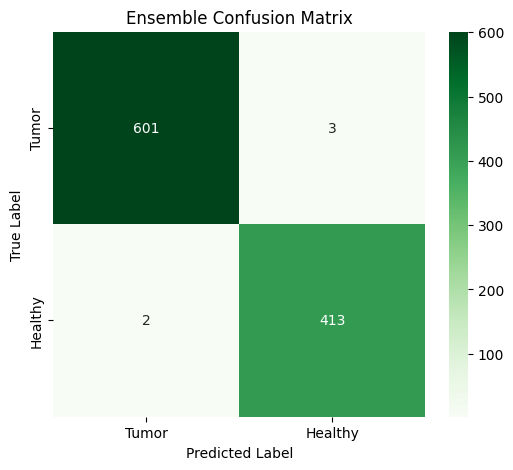

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

vgg_preds = vgg_model.predict(X_test)
hybrid_preds = hybrid_model.predict(X_test)

# Average the predictions
ensemble_preds_prob = (vgg_preds + hybrid_preds) / 2.0
ensemble_preds_classes = (ensemble_preds_prob > 0.5).astype(int).flatten()

print("--- ENSEMBLE MODEL EVALUATION ---\n")
ensemble_accuracy = accuracy_score(y_test, ensemble_preds_classes)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}\n")

print("Ensemble Classification Report:\n")
print(classification_report(y_test, ensemble_preds_classes, target_names=['Tumor', 'Healthy']))

print("\nEnsemble Confusion Matrix:\n")
cm = confusion_matrix(y_test, ensemble_preds_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Tumor', 'Healthy'], yticklabels=['Tumor', 'Healthy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Ensemble Confusion Matrix')
plt.show()

### Step 6: Visualize and Compare Training Histories

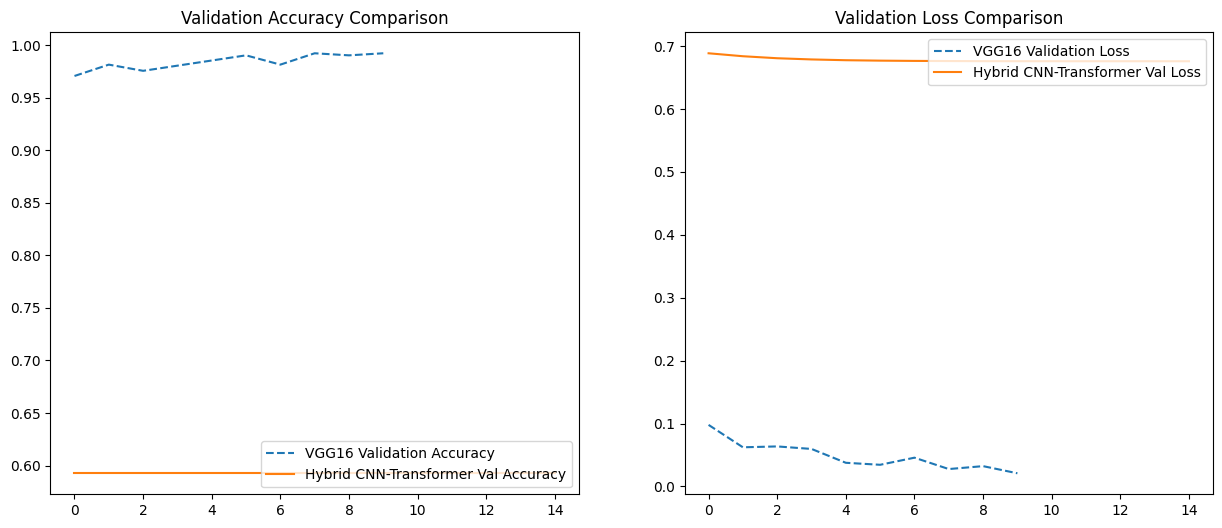

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy', linestyle='--')
plt.plot(hybrid_history.history['val_accuracy'], label='Hybrid CNN-Transformer Val Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss', linestyle='--')
plt.plot(hybrid_history.history['val_loss'], label='Hybrid CNN-Transformer Val Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss Comparison')

plt.show()

#Conclusion and Analysis
This project evaluated three different deep learning models for brain tumor detection using MRI scans: a VGG16 model using transfer learning, a hybrid CNN-Transformer model, and an ensemble combining these two. The results of all the approaches are provided below :

##1. VGG16 (Transfer Learning) (Accuracy: 98.85%)

The VGG16 model, using pre-trained weights from ImageNet, achieved a brilliant accuracy of 98.85%. This result shows the strength of transfer learning for medical imaging tasks.

##2. Hybrid CNN-Transformer (Accuracy: 59.24%)

The hybrid CNN-Transformer model, despite being a more modern architecture, performed poorly, with an accuracy of only 59.24%. The low performance is likely due to the model's complexity and the dataset's size.
##3. Ensemble Model (Accuracy: 99.51%)

The ensemble model, which is the average of the predictions of the VGG16 and the hybrid model, achieved the highest accuracy of 99.51%. TIt shows that even by combining a very strong model (VGG16) with a weak one (CNN-Transformer), the overall performance can be improved. The weak model, despite its low accuracy, likely provided a different "perspective" on the data, helping to correct a small number of misclassifications made by the VGG16 model alone.

##Final Summary:

This experiment confirms that transfer learning with VGG16 is the most reliable approach for this task. Ensembling stands out as a powerful technique to push performance even higher.